In [1]:
import pandas as pd
from utils_analysis import prepare_scores, plot_correlation
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv("data/hotpotqa/test.csv")

# "results/bart/r1/bart-base_data_hotpotqa_checkpoint-26835_hotpotqa.json",
# "results/bart/r2/bart-base_data_hotpotqa_checkpoint-26835_hotpotqa.json",
# "results/bart/r3/bart-base_data_hotpotqa_checkpoint-26835_hotpotqa.json",
# "results/t5/r1/flan-t5-base_data_hotpotqa_checkpoint-26835_hotpotqa.json",
# "results/t5/r2/flan-t5-base_data_hotpotqa_checkpoint-26835_hotpotqa.json",
# "results/t5/r3/flan-t5-base_data_hotpotqa_checkpoint-26835_hotpotqa.json",

df_scores, beam_search_results = prepare_scores(
    "results/bart/r3/bart-base_data_hotpotqa_checkpoint-26835_hotpotqa.json",
    df["target"],
    "f1",
)

/home/mila/f/floresl/beam-search/utils_analysis.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  abs(spearmanr(ground_truth_score, confidence_score_dict[str(k)]).statistic)  # type: ignore


In [3]:
df_scores.drop(["sentences", "dropout_sentences"], axis=1).corr(method="spearman")["f1"]

length_normalized_log_probs    0.208738
mean_token_entropy            -0.051106
dropout_bleu_variance         -0.067620
dropout_meteor_score           0.115049
dropout_entropy               -0.245361
dropout_disagreement          -0.139373
f1                             1.000000
beam_score_ratios_6            0.253526
beam_score_log_probs_6        -0.098399
beam_score_top_k_6            -0.052582
beam_score_impt_wt_6           0.040488
Name: f1, dtype: float64

In [4]:
beam_score_log_probs = pd.DataFrame(beam_search_results["beam_score_log_probs"])
worst_rouge_idxs = df_scores.sort_values(by="f1").index[:100]
best_rouge_idxs = df_scores.sort_values(by="f1").index[::-1][:100]

Text(0, 0.5, 'Joint Sequence Token Probability')

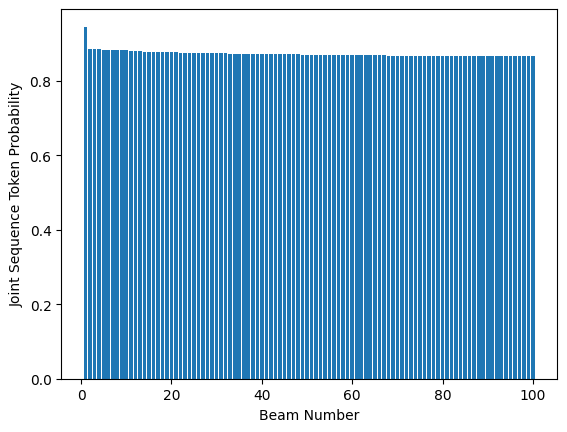

In [5]:
plt.bar(
    x=list(range(1, 101)),
    height=np.exp(beam_score_log_probs.loc[worst_rouge_idxs[0]]),
)
plt.xlabel("Beam Number")
plt.ylabel("Joint Sequence Token Probability")

Text(0, 0.5, 'Joint Sequence Token Probability')

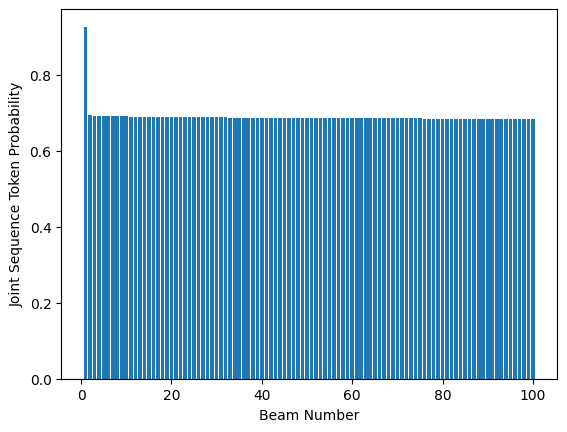

In [6]:
plt.bar(
    x=list(range(1, 101)),
    height=np.exp(beam_score_log_probs.loc[best_rouge_idxs[-1]]),
)
plt.xlabel("Beam Number")
plt.ylabel("Joint Sequence Token Probability")

/home/mila/f/floresl/miniconda3/envs/al/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mila/f/floresl/miniconda3/envs/al/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


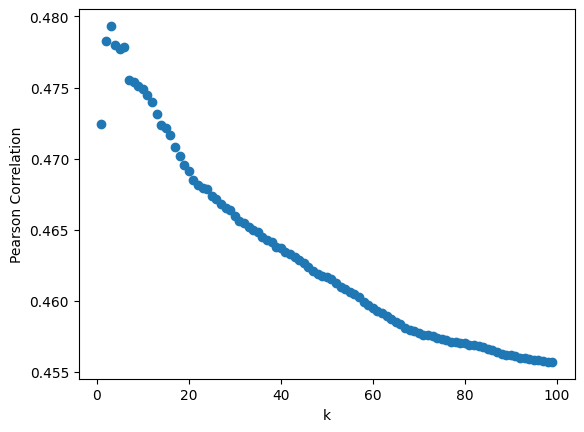

In [7]:
plot_correlation(beam_search_results["beam_score_ratios"], df_scores["f1"], "pearson")

/home/mila/f/floresl/beam-search/utils_analysis.py:103: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  float(spearmanr(score_dictionary[str(k)], metrics).statistic)  # type: ignore


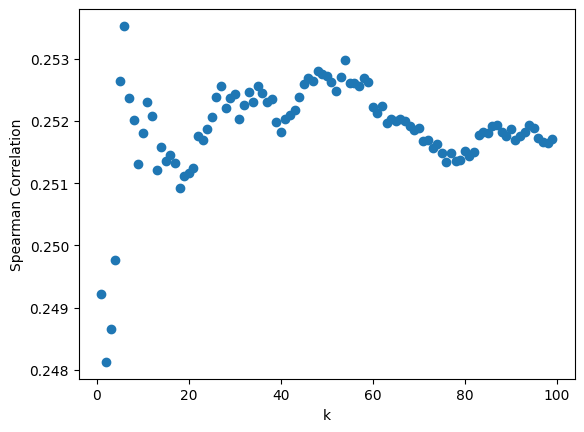

In [8]:
plot_correlation(beam_search_results["beam_score_ratios"], df_scores["f1"], "spearman")

In [9]:
from utils_tail_probs import softmax, tail_index
from scipy.stats import spearmanr

In [ ]:
tail_indices = []
for i in range(len(beam_score_log_probs)):
    probs = softmax(200 * beam_score_log_probs.iloc[i].to_numpy(), temperature=1)
    tail_indices.append(tail_index(probs))

spearmanr(tail_indices, df_scores["f1"])

SignificanceResult(statistic=0.2537071389131865, pvalue=3.7447441767809693e-16)

In [11]:
import json

baseline_probs = json.load(
    open(
        "/home/mila/f/floresl/beam-search/results/bart_baseline/facebook_bart-base_hotpotqa.json",
        "r",
    )
)

In [12]:
baseline_log_probs = baseline_probs["beam_score_log_probs"]

In [17]:
k = 0

In [18]:
spearmanr(
    [a - b for (a, b) in zip(beam_score_log_probs[str(k)], baseline_log_probs[str(k)])],
    df_scores["f1"],
)

SignificanceResult(statistic=0.2019831846819701, pvalue=1.1497038182483267e-10)